In [1]:
import socket
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd

from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu
import math
from datetime import datetime, timedelta
import cutax
from straxen.get_corrections import get_correction_from_cmt
from cutax.cuts import *

%load_ext autoreload
%autoreload 2
#import importlib
#importlib.reload(cutax)

In [2]:
straxen.print_versions()

,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/b...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/l...,None
2,straxen,1.8.1,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/l...,None
3,cutax,1.10.0,/dali/lgrandi/xenonnt/software/cutax/v1.10.0/c...,None


In [3]:
st = cutax.contexts.xenonnt_v8(cut_list=[cutax.cut_lists.basic.BasicCuts])
FiducialVolume = st.get_single_plugin('030000', 'cut_fiducial_volume')
NearWires = st.get_single_plugin('030000', 'cut_near_wires')

In [4]:
#ev_ar37 = pd.read_pickle('/dali/lgrandi/kazama/xenonnt/analysis/er_leakage/v8/Ar37_20220517_v8.pkl')
ev_ar37 = pd.read_pickle('/dali/lgrandi/kazama/xenonnt/analysis/er_leakage/v8/Ar37_20220619_v8_20220502_new_s2_width_s1_ss.pkl')

In [5]:
#evAr = ev_ar37[wcu.all_cuts(ev_ar37)]
ev_wimps = ev_ar37[wcu.all_cuts(ev_ar37,wimps=1)]

In [6]:
ev_low_er = ev_ar37[wcu.all_cuts(ev_ar37,low_er=1)]

In [7]:
ev_sim = np.load('/dali/lgrandi/shenyangshi/bdt_acceptance_0620.npy', allow_pickle=True).item()
ev_sim = ev_sim['wfsim']
ev_sim = ev_sim[FiducialVolume.cut_by(ev_sim)]

In [8]:
vd = get_correction_from_cmt('024075',('electron_drift_velocity', 'ONLINE', True))
gd = get_correction_from_cmt('024075',('electron_drift_time_gate', 'ONLINE', True))
dc = get_correction_from_cmt('024075',('electron_diffusion_cte', 'ONLINE', True))
par = (dc,vd,gd)
print(par)

(4.566e-08, 6.77e-05, 2700.0)


Fit lower boundary: [0.75785949 3.18263529 1.26349891]
Fit upper boundary: [4.74467848 1.34106577 1.99650474 1.02559667]
param_parabola_low: [ 0.01671567 -0.03387235  0.55147006]
param_parabola_high: [ 0.09961975 -0.99581728  3.73859258]
Cut: total 151538, survived 148970 -> 98.31%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:654: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


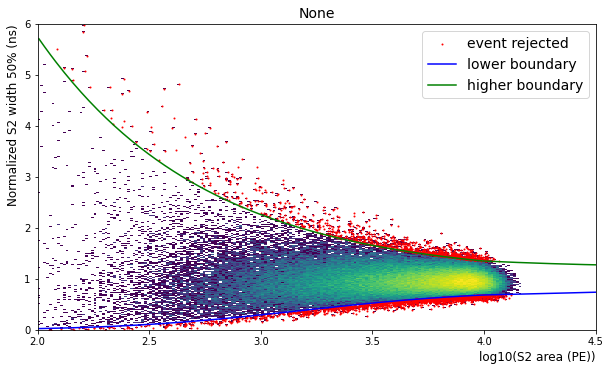

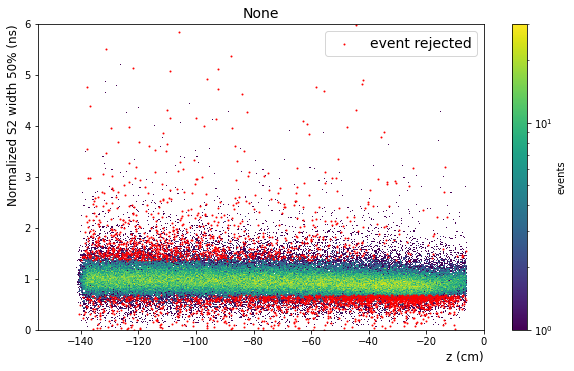

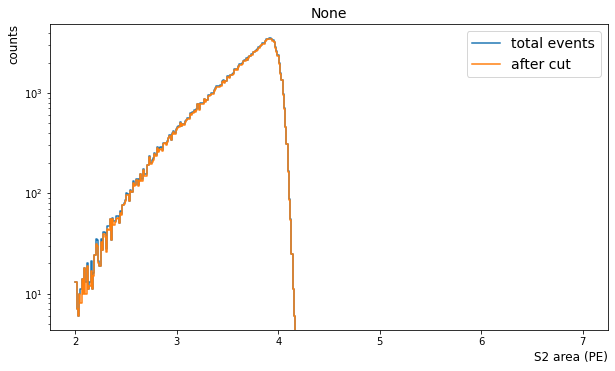

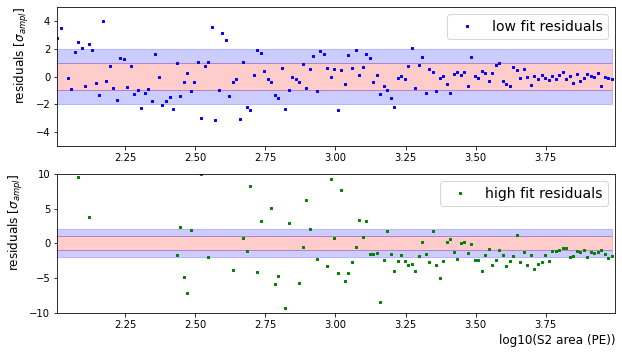

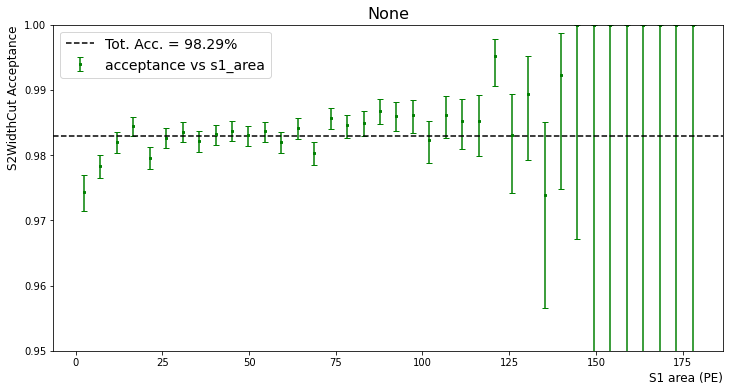

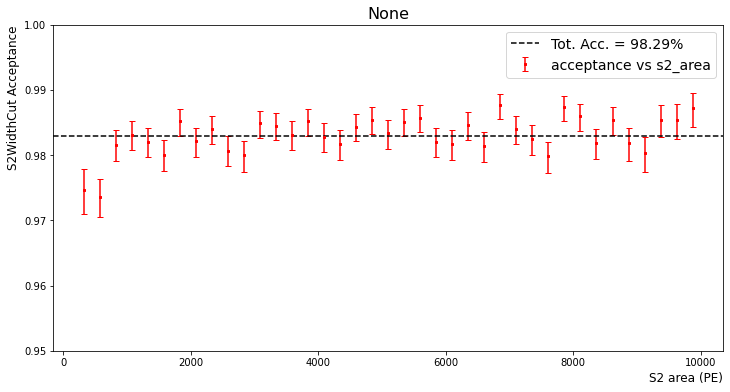

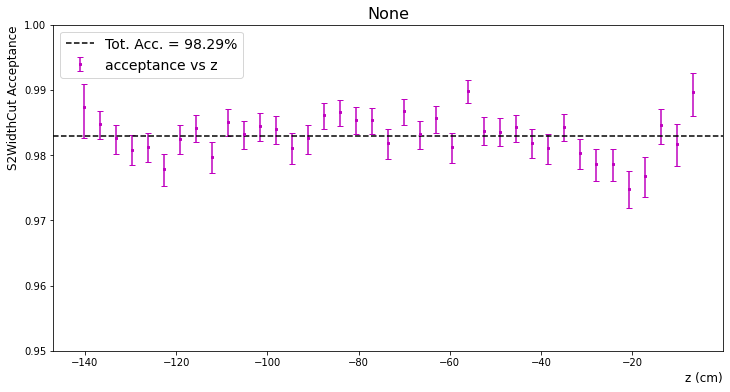

In [9]:
# FAR FROM WIRES 1-99%
cut_far, acc_sim_f = wcu.set_cut_on_data(ev_sim, par, width_type='50p', perc=(1,99),wrange=(0,6),
                                          alim=(0.95,1), afit=(2,4), acc_calc = 1,plot=1)

Fit lower boundary: [0.7742574  2.92714807 1.22338626]
Fit upper boundary: [4.74467848 1.34106577 1.99650474 1.02559667]


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:654: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


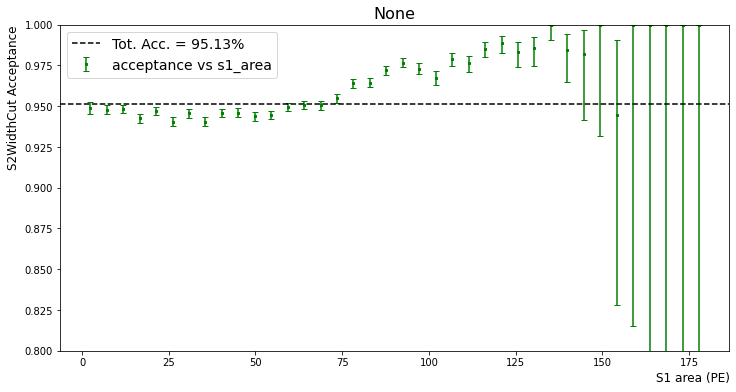

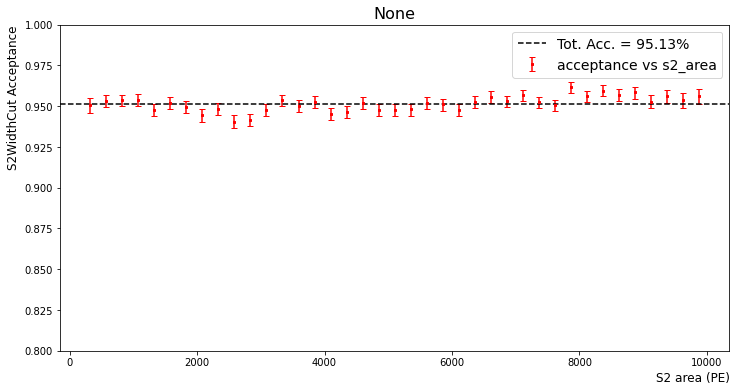

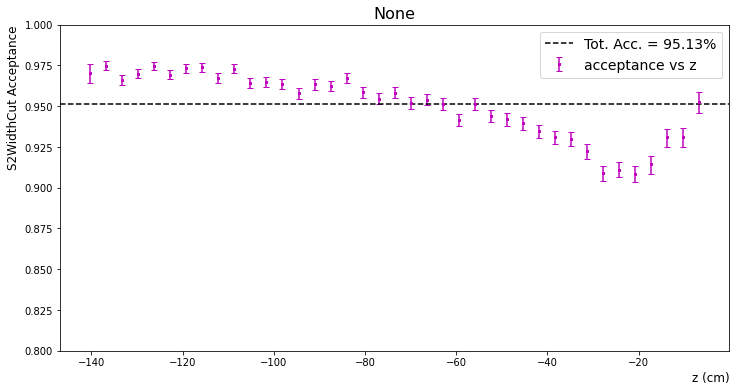

In [10]:
# NEAR WIRES WIMPs
cut_near, acc_sim_n = wcu.set_cut_on_data(ev_sim, par, width_type='50p',perc=(5,99),wrange=(0,6),
                                           alim=(0.8,1), afit=(2.,4), acc_calc=1,wire_model=1)

In [11]:
# get cut mask for WFsim near wires for LowER 1-99%
cut_mask_sim_low_er_near = wcu.S2WidthCut(ev_sim, title='WFsim near wires', mod_par=par, bins=400,
                                          wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                          ext_par=cut_far, near_wires=1, wire_model=1 )
cut_mask_sim_low_er_near = cut_mask_sim_low_er_near[1]
# get cut mask for WFsim far from wires for LowER 1-99%
cut_mask_sim_low_er_far = wcu.S2WidthCut(ev_sim, title='WFsim far wires', mod_par=par, bins=400,
                                        wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                        ext_par=cut_far)
cut_mask_sim_low_er_far = cut_mask_sim_low_er_far[1]
mask_near_wires = NearWires.cut_by(ev_sim)
cut_mask_sim_low_er_near[~mask_near_wires] = True
cut_mask_sim_low_er_far[mask_near_wires] = True 
cut_mask_sim_low_er = cut_mask_sim_low_er_near & cut_mask_sim_low_er_far

In [12]:
# get cut mask for WFsim near wires for WIMPs 1-99%
cut_mask_sim_wimps_near = wcu.S2WidthCut(ev_sim, title='WFsim near wires', mod_par=par, bins=400,
                                          wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                          ext_par=cut_far, near_wires=1, wire_model=1 )
cut_mask_sim_wimps_near = cut_mask_sim_wimps_near[1]
# get cut mask for WFsim far from wires for WIMPs 5-99%
cut_mask_sim_wimps_far = wcu.S2WidthCut(ev_sim, title='WFsim far wires', mod_par=par, bins=400,
                                        wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                        ext_par=cut_near)
cut_mask_sim_wimps_far = cut_mask_sim_wimps_far[1]
mask_near_wires = NearWires.cut_by(ev_sim)
cut_mask_sim_wimps_near[~mask_near_wires] = True
cut_mask_sim_wimps_far[mask_near_wires] = True 
cut_mask_sim_wimps = cut_mask_sim_wimps_near & cut_mask_sim_wimps_far

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634788 0.19632396]
param_parabola_high: [ 0.12086552 -1.22952077  4.37596573]
Cut: total 7637588, survived 7476758 -> 97.89%


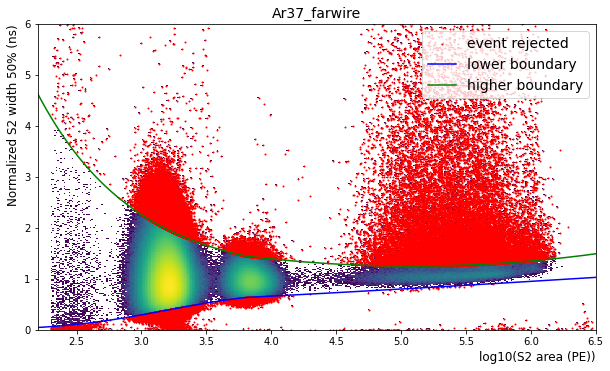

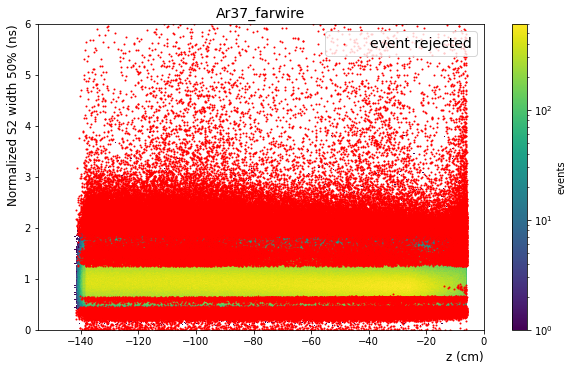

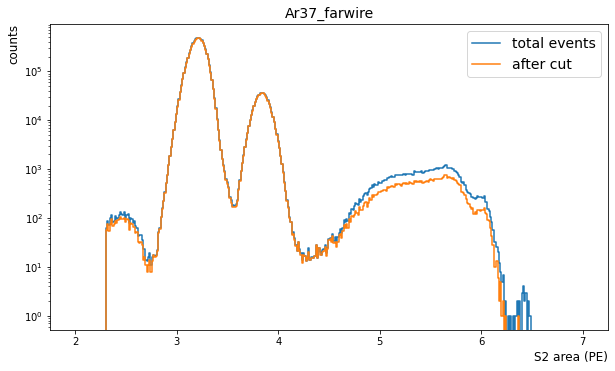

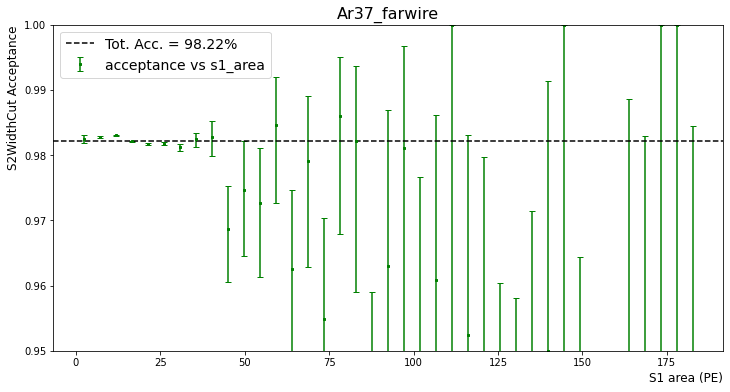

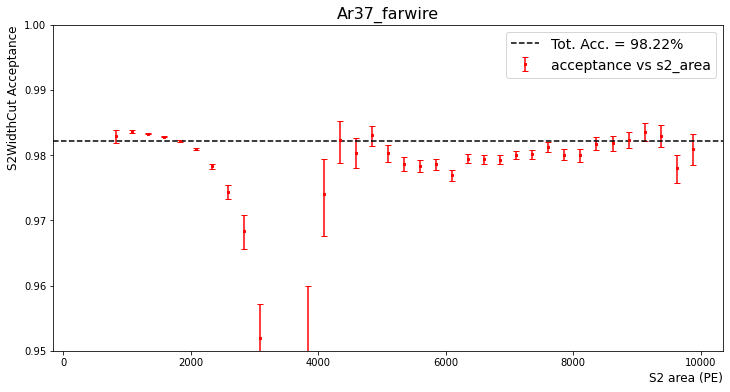

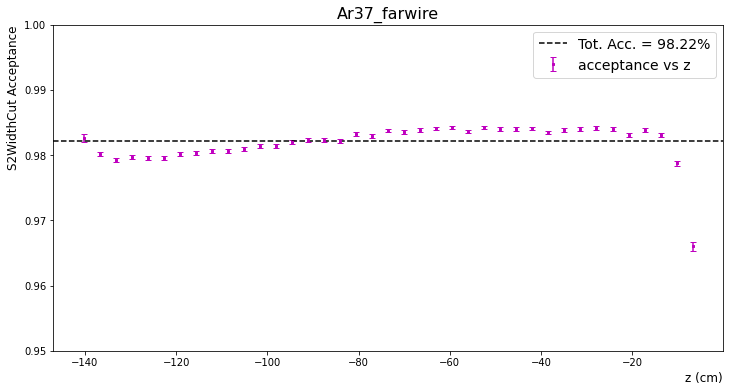

In [21]:
# FAR WIRES Ar37
acc_f = wcu.apply_cut_on_data(evAr, par, cut_far, width_type = '50p', far_wires = 1, wrange = (0,6),
                              acc_calc = 1,plot=1, alim=(0.95,1), info = 'Ar37_farwire')

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634788 0.19632396]
param_parabola_high: [ 0.12086552 -1.22952077  4.37596573]
Cut: total 1799650, survived 1788111 -> 99.36%


(       s1_area  s1_area_acc      s2_area  s2_area_acc           z     z_acc  \
 0     2.371795     0.992090   325.641026     0.920063 -140.243590  0.995388   
 1     7.115385     0.992708   576.923077     0.913978 -136.730769  0.994955   
 2    11.858974     0.993365   828.205128     0.995018 -133.217949  0.996211   
 3    16.602564     0.993828  1079.487179     0.995830 -129.705128  0.996186   
 4    21.346154     0.994409  1330.769231     0.995545 -126.192308  0.995586   
 5    26.089744     0.994892  1582.051282     0.994554 -122.679487  0.995906   
 6    30.833333     0.996261  1833.333333     0.993732 -119.166667  0.995609   
 7    35.576923     0.996241  2084.615385     0.992633 -115.653846  0.994973   
 8    40.320513     0.995012  2335.897436     0.991768 -112.141026  0.995636   
 9    45.064103     0.982955  2587.179487     0.990819 -108.628205  0.995272   
 10   49.807692     0.980769  2838.461538     0.989943 -105.115385  0.995436   
 11   54.551282     0.982456  3089.74359

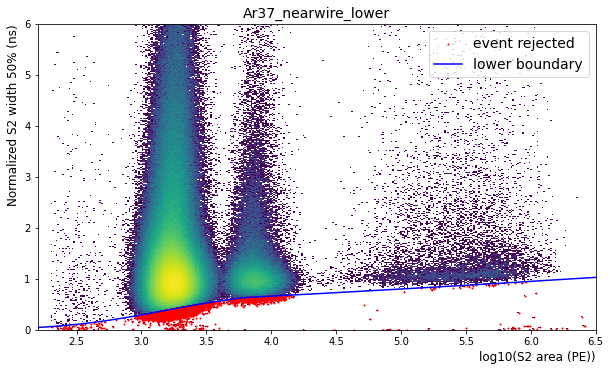

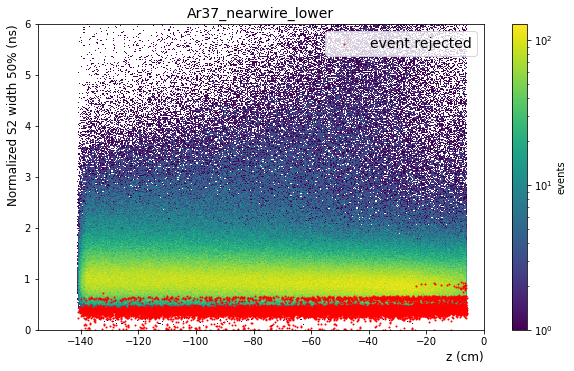

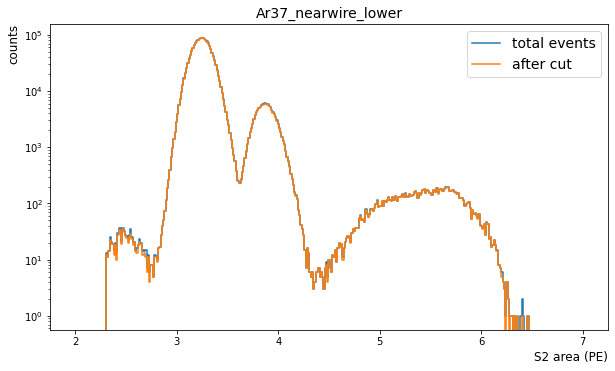

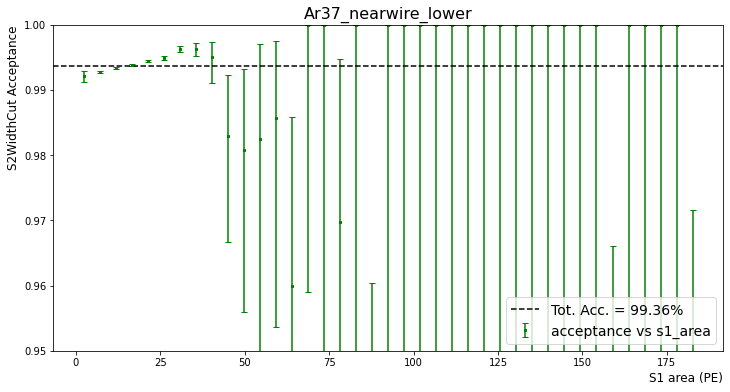

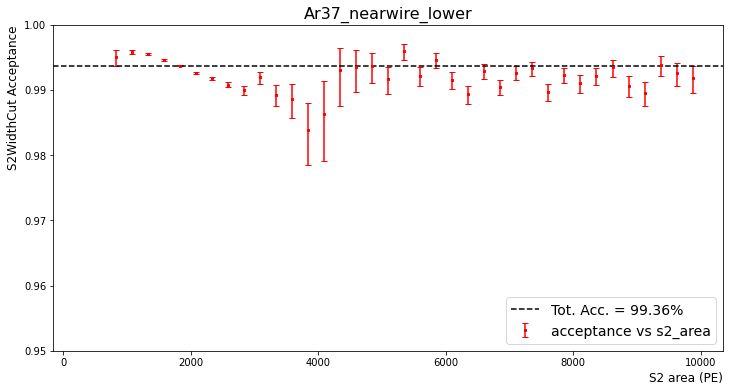

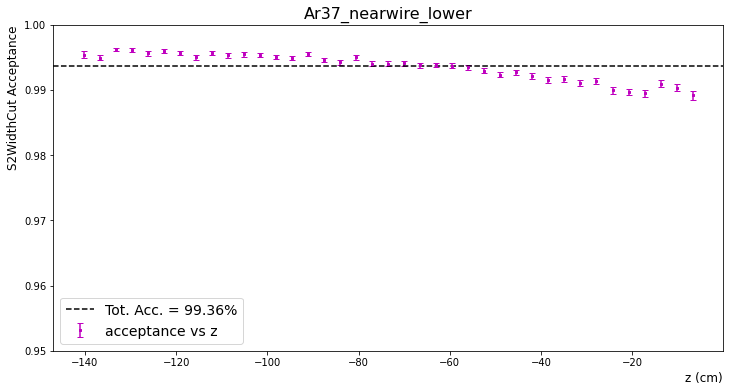

In [22]:
# NEAR WIRES Ar37
wcu.apply_cut_on_data(evAr, par, cut_far, width_type = '50p', near_wires = 1, wrange = (0,6),
                      acc_calc = 1,plot=1, alim=(0.95,1), info = 'Ar37_nearwire_lower')

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634788 0.19632396]
param_parabola_high: [ 0.12086552 -1.22952077  4.37596573]
Cut: total 1799650, survived 1788111 -> 99.36%
Cut wire modeled: total 1799650, survived 1780925 -> 98.96%


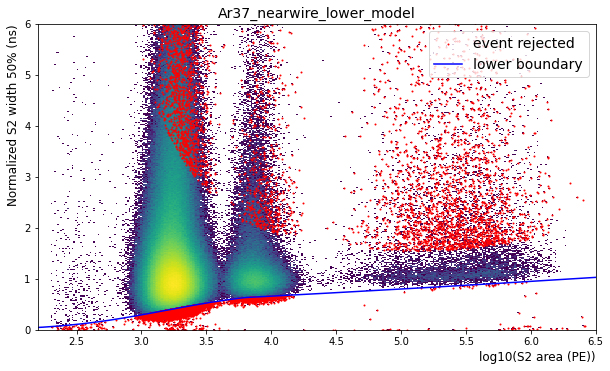

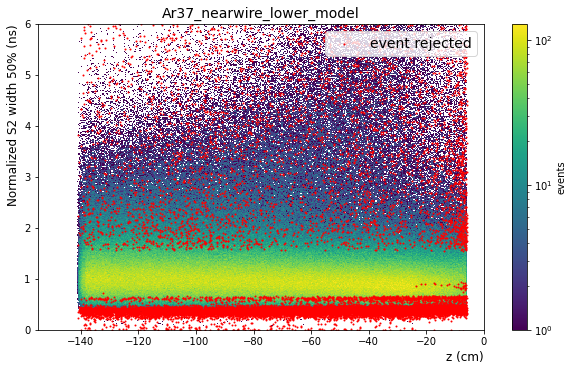

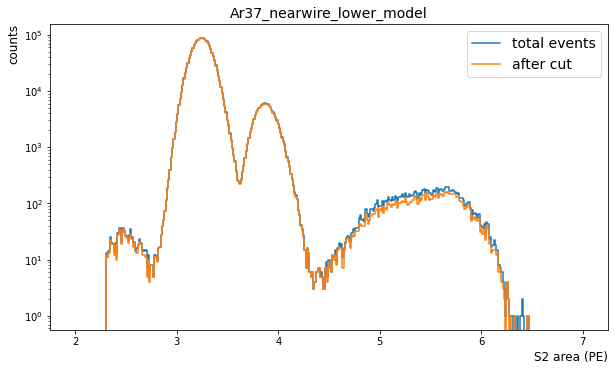

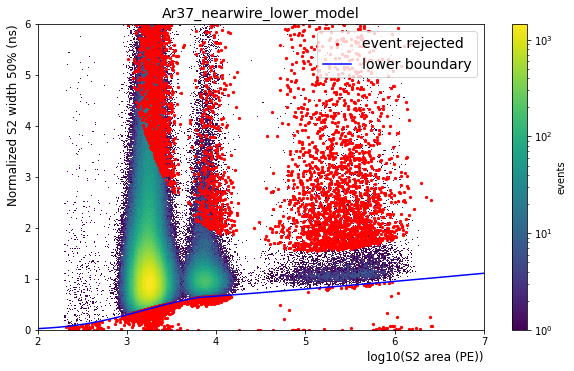

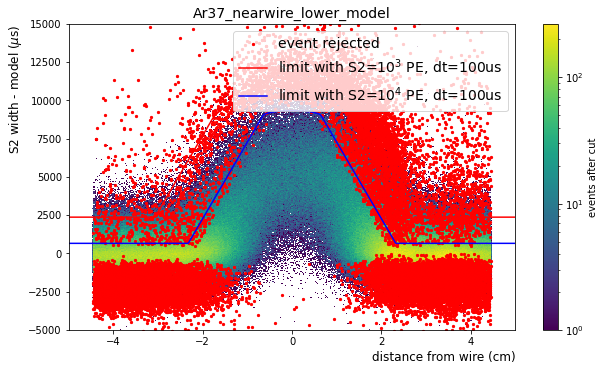

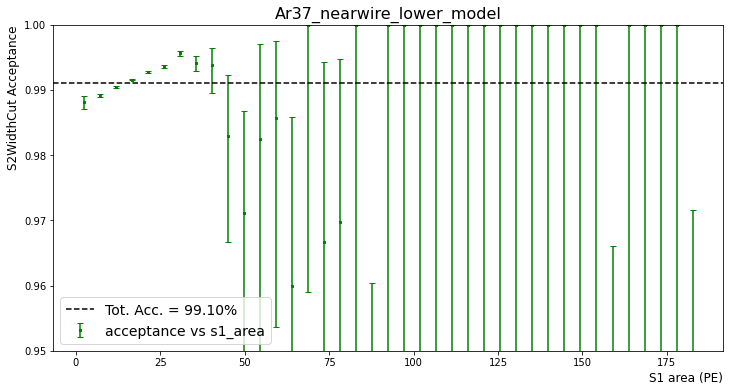

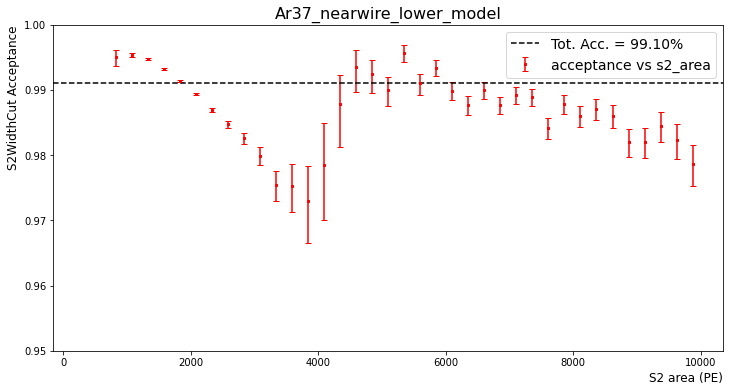

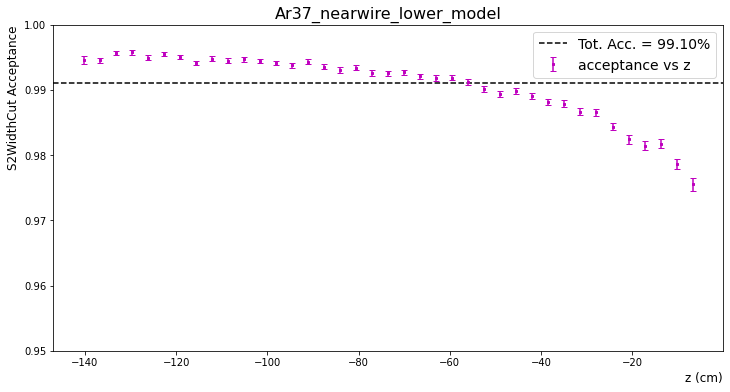

In [24]:
# NEAR WIRES WIRE MODEL Ar37
acc_n = wcu.apply_cut_on_data(evAr, par, cut_far, width_type = '50p', near_wires = 1, wrange = (0,6),
                              acc_calc = 1,plot=1, alim=(0.95,1),
                              info = 'Ar37_nearwire_lower_model',wire_model=1)

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:654: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


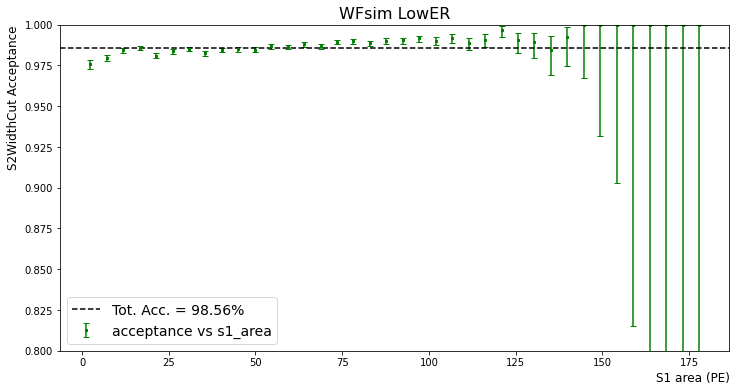

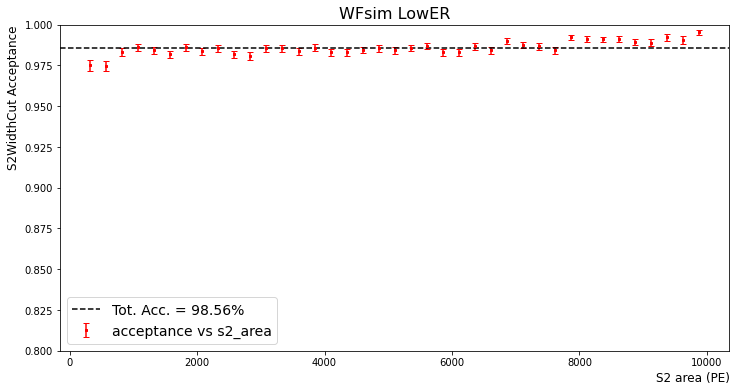

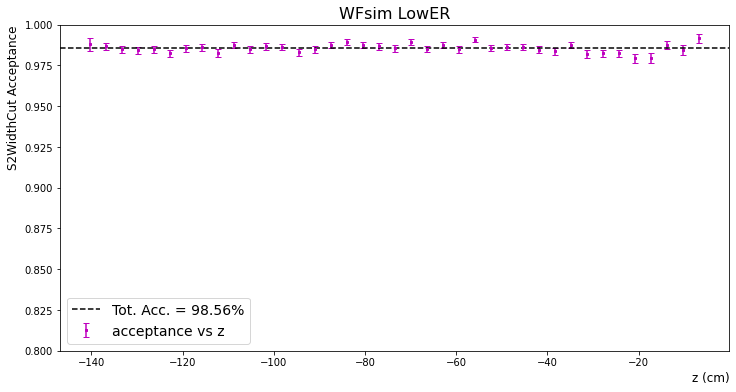

In [13]:
acc_sim_low_er = wcu.get_acceptance(ev_sim, cut_mask_sim_low_er, title='WFsim LowER', alim=(0.8,1))

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:654: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


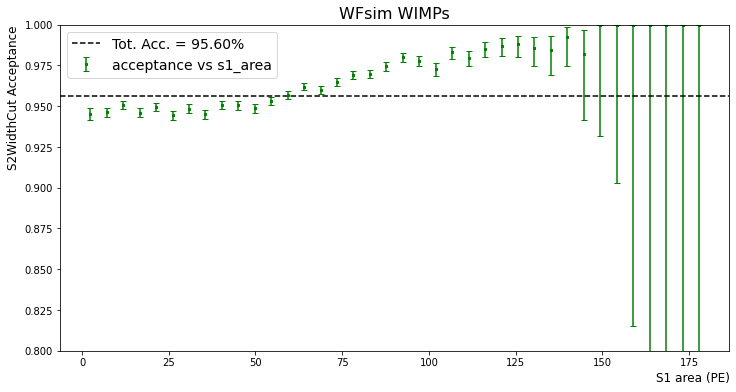

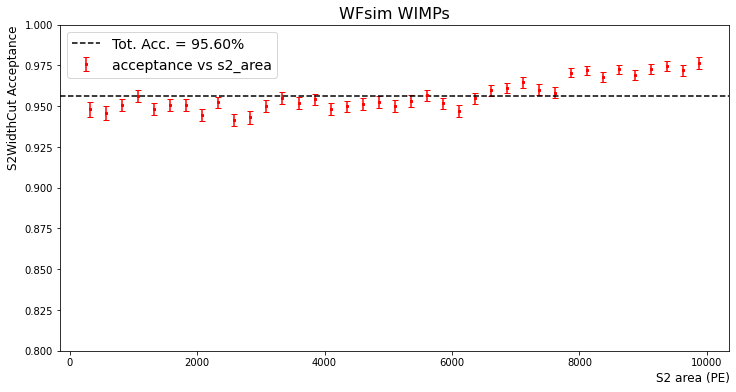

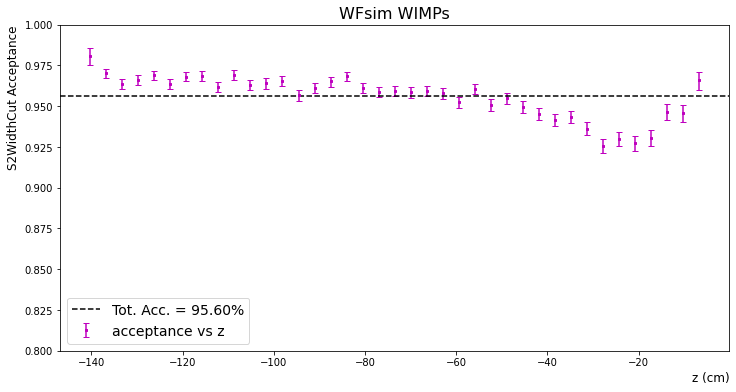

In [14]:
acc_sim_wimps = wcu.get_acceptance(ev_sim, cut_mask_sim_wimps, title='WFsim WIMPs', alim=(0.8,1))

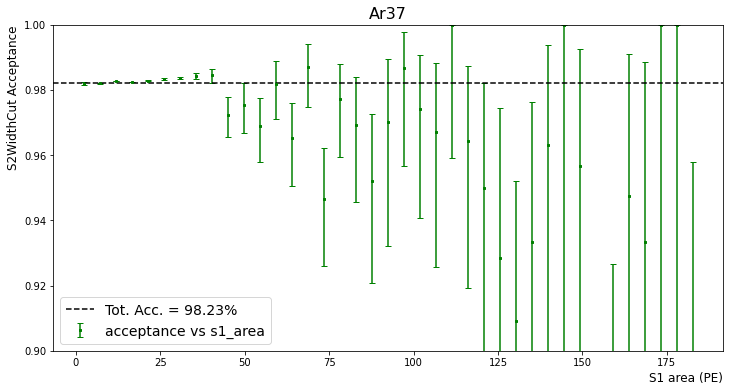

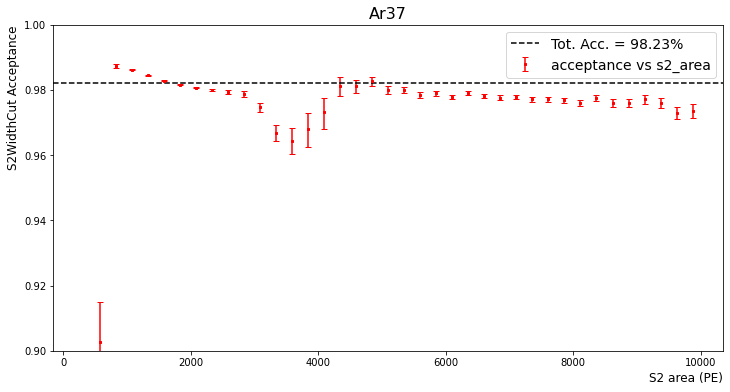

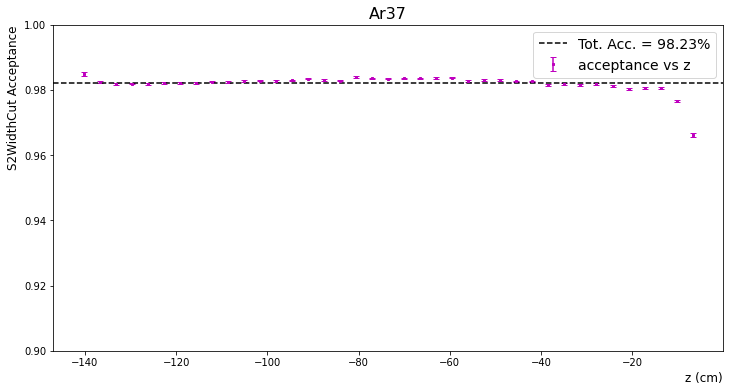

In [15]:
acc_low_er = wcu.get_acceptance(ev_low_er, ev_low_er['cut_s2_width_wire_modeled_low_er'], title='Ar37')

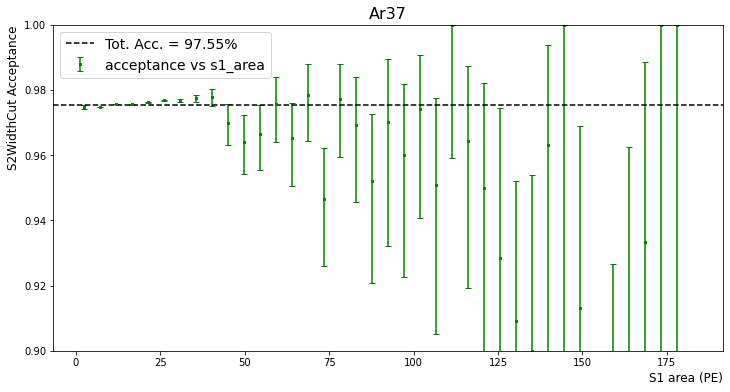

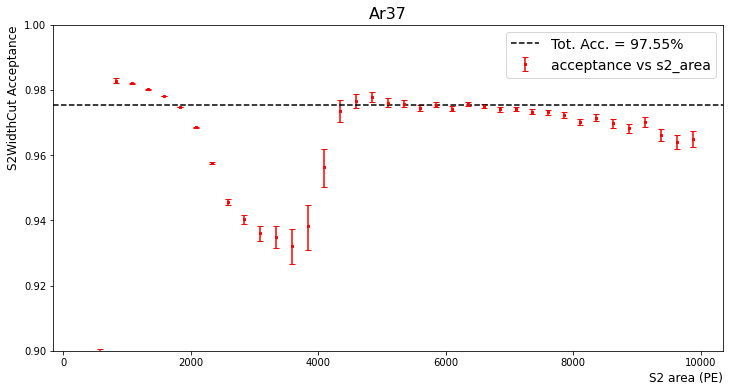

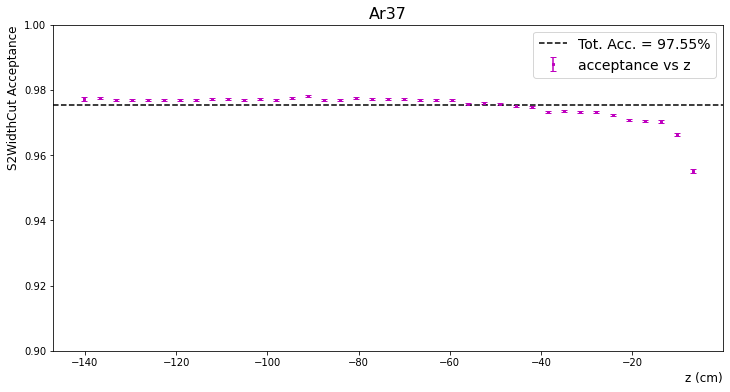

In [16]:
acc_wimps = wcu.get_acceptance(ev_wimps, ev_wimps['cut_s2_width_wire_modeled_wimps'], title='Ar37')

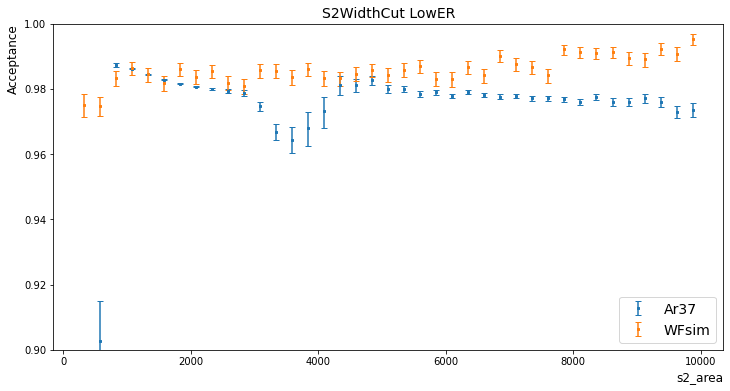

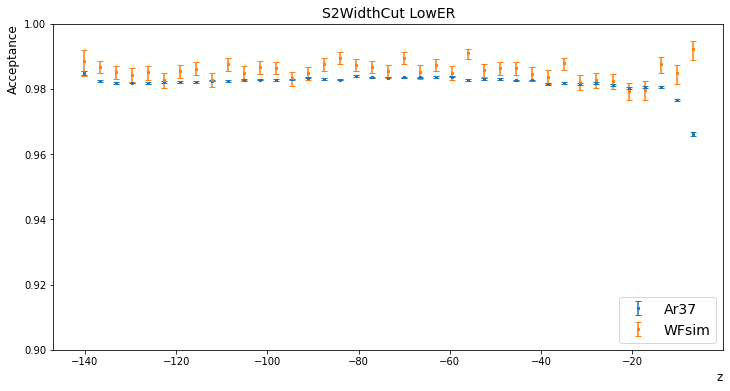

In [17]:
wcu.plot_acceptance(acc_low_er, acc_sim_low_er, alim=(0.9,1),title='S2WidthCut LowER',info='Ar37')

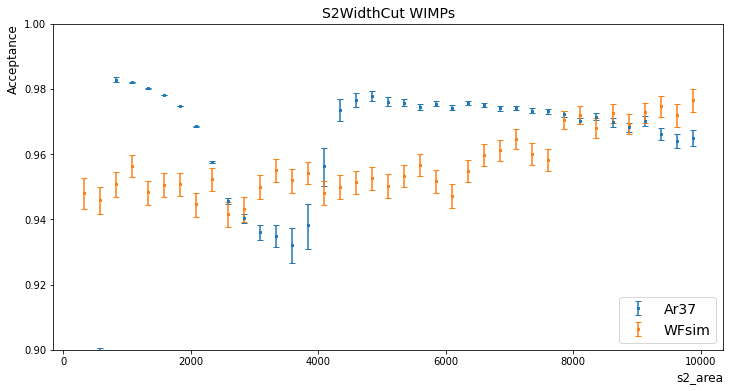

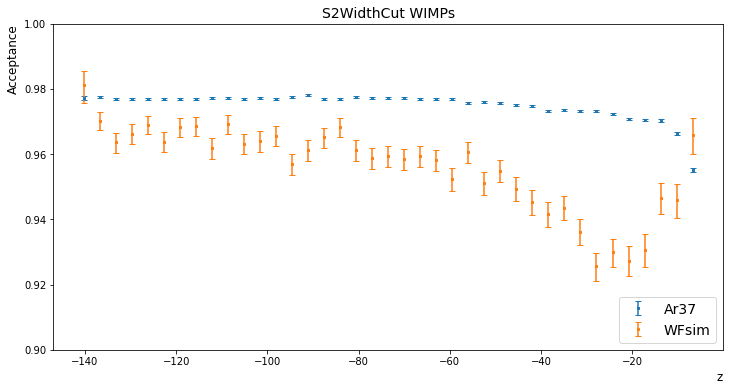

In [18]:
wcu.plot_acceptance(acc_wimps, acc_sim_wimps, alim=(0.9,1),title='S2WidthCut WIMPs',info='Ar37')

In [19]:
ev_rn220 = pd.read_pickle('/dali/lgrandi/kazama/xenonnt/analysis/er_leakage/v8/Rn220_20220619_v8_20220502_new_s2_width_s1_ss.pkl')
evRn_w = ev_rn220[wcu.all_cuts(ev_rn220,wimps=1)]
evRn_l = ev_rn220[wcu.all_cuts(ev_rn220,low_er=1)]

In [ ]:
evWIMPs = pd.concat([evRn_w[evRn_w['s2_area']>2500],ev_wimps[ev_wimps['s2_area']<2500]])

In [ ]:
evLowER = pd.concat([evRn_l[evRn_l['s2_area']>2500],ev_low_er[ev_low_er['s2_area']<2500]])

In [ ]:
accLowER = wcu.get_acceptance(evLowER, evLowER['cut_s2_width_wire_modeled_low_er'],
                              title='Ar37+Rn220 LowER')

In [ ]:
accWIMPs = wcu.get_acceptance(evWIMPs, evWIMPs['cut_s2_width_wire_modeled_low_er'],
                              title='Ar37+Rn220 WIMPs')